<div align="center">

# <span style="color: #3498db;">CA2 - Genetic & Game</span>

**<span style="color:rgb(247, 169, 0);">Ali Sadeghi Maharluee</span> - <span style="color:rgb(143, 95, 195);">810102471</span>**

</div>


In [177]:
import matplotlib.pyplot as plt

# <span style="color: #3498db;">Genetic Algorithm</span>

In [178]:
import random
import itertools
import numpy as np
from tqdm import tqdm
from scipy import stats
import time


metrics = [
    "rmse", 
    "mae", 
    "mse", 
    "max_error", 
    "r2", 
    "mape", 
    "weighted_rmse", 
    "frequency_domain_error", 
    "normalized_cross_correlation"
]

In [179]:
# Algorithm parameters
NUM_COEFFS = 41  # a0, a1 to a20, b1 to b20
POPULATION_SIZE = 100
GENERATIONS = 100
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.5
SELECTION_RATE = 0.5
FUNCTION_RANGE = (-np.pi, np.pi)
SAMPLE_COUNT = 100
A = 3 # Domain of coefficients [-A, A]
ELITISM_RATE = 0.14 

In [180]:
# Target functions
def get_target_function(function_name="sin_cos"):
    def sin_cos_function(t):
        """Target function: sin(2πt) + 0.5*cos(4πt)."""
        return np.sin(2 * np.pi * t) + 0.5 * np.cos(4 * np.pi * t)

    def linear_function(t):
        """Simple linear function: y = 2t + 1."""
        return 2 * t + 1

    def quadratic_function(t):
        """Quadratic function: y = 4t^2 - 4t + 2."""
        return 4 * (t**2) - 4 * t + 2

    def cubic_function(t):
        """Cubic function: y = 8t^3 - 12t^2 + 6t."""
        return 8 * (t**3) - 12 * (t**2) + 6 * t

    def gaussian_function(t):
        """Gaussian function centered at t=0.5."""
        mu = 0.5
        sigma = 0.1  # Adjust sigma to control the width of the peak
        return np.exp(-((t - mu) ** 2) / (2 * sigma**2))

    def square_wave_function(t):
        """Approximation of a square wave. Smoothed for better Fourier approximation."""
        return 0.5 * (np.sign(np.sin(2 * np.pi * t)) + 1)

    def sawtooth_function(t):
        """Sawtooth wave, normalized to [0, 1]."""
        return (t * 5) % 1

    def complex_fourier_function(t):
        return (
            np.sin(2 * np.pi * t)
            + 0.3 * np.cos(4 * np.pi * t)
            + 0.2 * np.sin(6 * np.pi * t)
            + 0.1 * np.cos(8 * np.pi * t)
        )

    def polynomial_function(t):
        return 10 * (t**5) - 20 * (t**4) + 15 * (t**3) - 4 * (t**2) + t + 0.5

    function_options = {
        "sin_cos": sin_cos_function,
        "linear": linear_function,
        "quadratic": quadratic_function,
        "cubic": cubic_function,
        "gaussian": gaussian_function,
        "square_wave": square_wave_function,
        "sawtooth": sawtooth_function,
        "complex_fourier": complex_fourier_function,
        "polynomial": polynomial_function,
    }

    selected_function = function_options.get(function_name.lower())
    if selected_function:
        return selected_function
    else:
        print(f"Warning: Function '{function_name}' not found. Using default sin_cos function.")
        return sin_cos_function


In [181]:
class GeneticAlgorithm:
    def __init__(
        self,
        target_function_name="sin_cos",
        population_size=POPULATION_SIZE,
        generations=GENERATIONS,
        mutation_rate=MUTATION_RATE,
        crossover_rate = CROSSOVER_RATE,
        selection_method='tournament',  # 'tournament','roulette','rank'
        crossover_method='two_point',   # 'two_point','uniform','arithmetic','sbx'
        mutation_strategy='uniform',    # 'uniform','gaussian','directed'
        elitism_rate=ELITISM_RATE,
        coeff_range=A,
        sample_count=SAMPLE_COUNT,
        fitness_metric="rmse",
        adaptive_params=True
    ):
        self.target_fn_name = target_function_name
        self.target_fn = get_target_function(target_function_name)
        self.pop_size = population_size
        self.gens = generations
        self.mut_rate = mutation_rate
        self.cross_rate = crossover_rate
        self.sel_method = selection_method
        self.cross_method = crossover_method
        self.mut_strategy = mutation_strategy
        self.elitism_rate = elitism_rate
        self.coeff_bound = coeff_range
        self.sample_count = sample_count
        self.fitness_metric = fitness_metric.lower()
        self.adaptive = adaptive_params

        # Prepare data
        self.t_vals = np.linspace(*FUNCTION_RANGE, sample_count)
        self.target_vals = self.target_fn(self.t_vals)
        self.population = self._init_population()
        
        self.fitness_invert = self.fitness_metric in ["r2", "normalized_cross_correlation"]
        
        # History logs
        self.history = {
            'best': [], 'avg': [], 'worst': [], 'diversity': []
        }
        self.best_ind = None
        self.best_fit = float('inf')
        self.all_metrics = {} 
        
    def _init_population(self):
        # Latin Hypercube sampling or uniform
        return [np.random.uniform(-self.coeff_bound, self.coeff_bound, NUM_COEFFS)
                for _ in range(self.pop_size)]

    def _fourier(self, coeffs, t):
        a0 = coeffs[0]/2
        a = coeffs[1:21]; b = coeffs[21:]
        return a0 + sum(a[n-1]*np.cos(n*t) + b[n-1]*np.sin(n*t) for n in range(1,21))
    
    def _eval(self, ind):
        """Calculate fitness using the selected metric."""
        approx = np.array([self._fourier(ind, t) for t in self.t_vals])
        
        # Use the selected fitness metric
        if self.fitness_metric == "rmse":
            return self.calculate_rmse(approx)
        elif self.fitness_metric == "mae":
            return self.calculate_mae(approx)
        elif self.fitness_metric == "mse":
            return self.calculate_mse(approx)
        elif self.fitness_metric == "r2":
            # For R², we want to maximize, so return negative value for minimization
            return -self.calculate_r2(approx)
        elif self.fitness_metric == "max_error":
            return self.calculate_max_error(approx)
        elif self.fitness_metric == "weighted_rmse":
            return self.calculate_weighted_rmse(approx)
        elif self.fitness_metric == "mape":
            return self.calculate_mape(approx)
        elif self.fitness_metric == "frequency_domain_error":
            return self.calculate_frequency_domain_error(approx)
        elif self.fitness_metric == "normalized_cross_correlation":
            return -self.calculate_normalized_cross_correlation(approx)
        else:
            # Default to RMSE
            return self.calculate_rmse(approx)
    
    # Error metrics
    def calculate_rmse(self, approximated_values):
        """Root Mean Square Error"""
        return np.sqrt(np.mean((approximated_values - self.target_vals) ** 2))
    
    def calculate_mae(self, approximated_values):
        """Mean Absolute Error"""
        return np.mean(np.abs(approximated_values - self.target_vals))
    
    def calculate_mse(self, approximated_values):
        """Mean Squared Error"""
        return np.mean((approximated_values - self.target_vals) ** 2)
    
    def calculate_max_error(self, approximated_values):
        """Maximum Absolute Error"""
        return np.max(np.abs(approximated_values - self.target_vals))
    
    def calculate_r2(self, approximated_values):
        """R² Coefficient of Determination"""
        ss_total = np.sum((self.target_vals - np.mean(self.target_vals)) ** 2)
        ss_residual = np.sum((self.target_vals - approximated_values) ** 2)
        
        if ss_total == 0:  # Avoid division by zero
            return 0
        
        return 1 - (ss_residual / ss_total)
    
    def calculate_mape(self, approximated_values):
        """Mean Absolute Percentage Error"""
        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-10
        return np.mean(np.abs((self.target_vals - approximated_values) / (np.abs(self.target_vals) + epsilon))) * 100
    
    def calculate_weighted_rmse(self, approximated_values):
        """Weighted RMSE - Gives more weight to errors in regions with high curvature"""
        # Calculate numerical second derivative as a measure of curvature
        target_diff = np.diff(self.target_vals, 2)
        # Add zeros for endpoints to match original size
        curvature = np.abs(np.pad(target_diff, (1, 1), 'constant'))
        # Normalize weights to sum to 1
        weights = curvature / (np.sum(curvature) + 1e-10)
        
        # Weighted RMSE
        return np.sqrt(np.sum(weights * (approximated_values - self.target_vals) ** 2))
    
    def calculate_frequency_domain_error(self, approximated_values):
        """Error in frequency domain (using FFT)"""
        target_fft = np.abs(np.fft.fft(self.target_vals))
        approx_fft = np.abs(np.fft.fft(approximated_values))
        return np.mean(np.abs(target_fft - approx_fft))
    
    def calculate_normalized_cross_correlation(self, approximated_values):
        """Normalized Cross-Correlation"""
        # Normalize signals to zero mean and unit variance
        target_norm = (self.target_vals - np.mean(self.target_vals)) / (np.std(self.target_vals) + 1e-10)
        approx_norm = (approximated_values - np.mean(approximated_values)) / (np.std(approximated_values) + 1e-10)
        
        # Calculate correlation
        correlation = np.correlate(target_norm, approx_norm, mode='valid')[0] / len(target_norm)
        
        return correlation
    
    def calculate_all_metrics(self, individual):
        """Calculate all available metrics for a given individual."""
        approximated_values = np.array([self._fourier(individual, t) for t in self.t_vals])
        
        metrics = {
            "RMSE": self.calculate_rmse(approximated_values),
            "MAE": self.calculate_mae(approximated_values),
            "MSE": self.calculate_mse(approximated_values),
            "Max Error": self.calculate_max_error(approximated_values),
            "R²": self.calculate_r2(approximated_values),
            "MAPE (%)": self.calculate_mape(approximated_values),
            "Weighted RMSE": self.calculate_weighted_rmse(approximated_values),
            "Frequency Domain Error": self.calculate_frequency_domain_error(approximated_values),
            "Normalized Cross-Correlation": self.calculate_normalized_cross_correlation(approximated_values)
        }
        
        return metrics
    
    def _compute_diversity(self):
        # average pairwise L2 distance
        pts = np.array(self.population)
        dists = np.sqrt(((pts[:,None,:]-pts[None,:,:])**2).sum(axis=2))
        return np.mean(dists)
    
    # Selection methods
    def _select(self, fits):
        if self.sel_method=='tournament':
            parents=[]
            for _ in range(self.pop_size):
                i,j,k = random.sample(range(self.pop_size),3)
                trio = [i,j,k]
                winner = trio[np.argmin([fits[x] for x in trio])]
                parents.append(winner)
            return parents
        
        elif self.sel_method=='roulette':
            fits_array = np.array(fits)
            min_fit = np.min(fits_array)
            
            if min_fit <= 0: 
                fits_array = fits_array - min_fit + 1e-6

            inv = 1 / (fits_array + 1e-10)
            probs = inv/np.sum(inv)
            return list(np.random.choice(range(self.pop_size), self.pop_size, p=probs))
        
        elif self.sel_method=='rank':
            ranks = np.argsort(np.argsort(fits))
            probs = ranks/np.sum(ranks)
            return list(np.random.choice(range(self.pop_size), self.pop_size, p=probs))

    # Crossover methods
    def _crossover(self, p1, p2):
        if random.random()>self.cross_rate: return p1.copy()
        if self.cross_method=='two_point':
            i,j = sorted(random.sample(range(1,NUM_COEFFS),2))
            return np.concatenate([p1[:i], p2[i:j], p1[j:]])
        elif self.cross_method=='uniform':
            mask = np.random.rand(NUM_COEFFS)<0.5
            return np.where(mask, p1, p2)
        elif self.cross_method=='arithmetic':
            alpha = random.random()
            return alpha*p1 + (1-alpha)*p2
        elif self.cross_method=='sbx':
            # simplified SBX
            child = p1.copy()
            for i in range(NUM_COEFFS):
                if random.random()<0.5:
                    beta = (2*random.random())**(1/(1+2))
                    child[i] = 0.5*((1+beta)*p1[i] + (1-beta)*p2[i])
            return child
        
    
    # Mutation methods
    def _mutate(self, ind, gen):
        for i in range(NUM_COEFFS):
            if random.random()<self.mut_rate:
                if self.mut_strategy=='uniform':
                    ind[i] += random.uniform(-self.coeff_bound/5, self.coeff_bound/5)
                elif self.mut_strategy=='gaussian':
                    sd = self.coeff_bound*(1-gen/self.gens)
                    ind[i] += random.gauss(0, sd)
                elif self.mut_strategy=='directed' and self.best_ind is not None:
                    eps = 0.1
                    ind[i] += eps*(self.best_ind[i]-ind[i])
                ind[i] = np.clip(ind[i], -self.coeff_bound, self.coeff_bound)
        return ind
    
    def evolve(self):
        for gen in tqdm(range(self.gens), desc=f"Evolving({self.target_fn_name})"):
            fits = [self._eval(ind) for ind in self.population]

            best, worst = min(fits), max(fits)
            avg = sum(fits)/self.pop_size
            div = self._compute_diversity()
            self.history['best'].append(best)
            self.history['avg'].append(avg)
            self.history['worst'].append(worst)
            self.history['diversity'].append(div)

            idx = int(np.argmin(fits))
            if fits[idx]<self.best_fit:
                self.best_fit, self.best_ind = fits[idx], self.population[idx].copy()

            # adaptive param adjustment
            if self.adaptive:
                self.mut_rate = MUTATION_RATE*(1-gen/self.gens)

            # selection
            parents_idx = self._select(fits)
            new_pop = []
            # elitism
            elite_count = max(1, int(self.elitism_rate*self.pop_size))
            elites = sorted(range(self.pop_size), key=lambda i:fits[i])[:elite_count]
            for i in elites: new_pop.append(self.population[i].copy())
            # generate rest
            while len(new_pop)<self.pop_size:
                p1 = self.population[random.choice(parents_idx)]
                p2 = self.population[random.choice(parents_idx)]
                child = self._crossover(p1,p2)
                child = self._mutate(child, gen)
                new_pop.append(child)
            self.population = new_pop
            
            if gen % 10 == 0:
                fitness_display = self.best_fit
                if self.fitness_invert:
                    fitness_display = -fitness_display
                print(f"Generation {gen}: Best {self.fitness_metric.upper()} = {fitness_display:.6f}")
    
    def plot_results(self):
        gens = list(range(self.gens))
        # Fitness range
        plt.figure(figsize=(12,5))
        plt.plot(gens, self.history['best'], label='Best')
        plt.plot(gens, self.history['avg'], label='Average')
        plt.plot(gens, self.history['worst'], label='Worst')
        plt.plot(gens, self.history['diversity'], label='Diversity')
        plt.legend(); plt.title(f"GA Performance ({self.target_fn_name})"); plt.xlabel('Gen'); plt.ylabel('Value'); plt.grid(True)
        plt.show()
        
        print("\n=== Final Metrics for Best Individual ===")
        for metric_name, value in self.all_metrics.items():
            print(f"{metric_name}: {value:.6f}")

    
    def get_best_coefficients(self):
        """Return the best coefficients found."""
        coeffs = {}
        coeffs['a0'] = self.best_ind[0]
        
        for i in range(1, 21):
            coeffs[f'a{i}'] = self.best_ind[i]
            coeffs[f'b{i}'] = self.best_ind[i+20]
            
        return coeffs
    
    def print_all_metrics(self):
        """Print all error metrics for the best solution."""
        print("\n--- Error Metrics for Best Solution ---")

        sorted_metrics = sorted(self.all_metrics.items())
        
        max_name_length = max(len(name) for name, _ in sorted_metrics)
        
        for name, value in sorted_metrics:
            # Format based on the metric
            if name == "R²" or name == "Normalized Cross-Correlation":
                print(f"{name:{max_name_length}}: {value:.6f} (higher is better)")
            elif name == "MAPE (%)":
                print(f"{name:{max_name_length}}: {value:.6f}%")
            else:
                print(f"{name:{max_name_length}}: {value:.6f}")
    
    def plot_approximation_vs_target(self):
        best_approx = np.array([self._fourier(self.best_ind, t) for t in self.t_vals])
        
        plt.figure(figsize=(10, 4))
        plt.plot(self.t_vals, self.target_vals, label='Target Function', linewidth=2)
        plt.plot(self.t_vals, best_approx, '--', label='Fourier Approximation', linewidth=2)
        plt.title(f"Approximation vs Target ({self.target_fn_name})")
        plt.xlabel("t")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [187]:
def run_experiments(
    functions=['sin_cos','linear','quadratic'],
    metrics=['rmse'],
    **ga_kwargs
):
    results = {}
    for fn in functions:
        results[fn] = {}
        for met in metrics:
            ga = GeneticAlgorithm(target_fn_name=fn, fitness_metric=met, **ga_kwargs)
            ga.evolve()
            ga.plot_results()
            results[fn][met] = ga.best_fit
    return results

Evolving(sin_cos):   1%|          | 1/100 [00:00<00:34,  2.91it/s]

Generation 0: Best MSE = 34.743259


Evolving(sin_cos):  11%|█         | 11/100 [00:03<00:30,  2.95it/s]

Generation 10: Best MSE = 4.564676


Evolving(sin_cos):  21%|██        | 21/100 [00:07<00:27,  2.89it/s]

Generation 20: Best MSE = 2.483456


Evolving(sin_cos):  31%|███       | 31/100 [00:10<00:23,  2.98it/s]

Generation 30: Best MSE = 1.555219


Evolving(sin_cos):  41%|████      | 41/100 [00:14<00:20,  2.88it/s]

Generation 40: Best MSE = 1.054582


Evolving(sin_cos):  51%|█████     | 51/100 [00:17<00:17,  2.74it/s]

Generation 50: Best MSE = 0.882913


Evolving(sin_cos):  61%|██████    | 61/100 [00:21<00:14,  2.76it/s]

Generation 60: Best MSE = 0.649091


Evolving(sin_cos):  71%|███████   | 71/100 [00:24<00:10,  2.88it/s]

Generation 70: Best MSE = 0.441952


Evolving(sin_cos):  81%|████████  | 81/100 [00:28<00:06,  2.78it/s]

Generation 80: Best MSE = 0.354685


Evolving(sin_cos):  91%|█████████ | 91/100 [00:32<00:03,  2.75it/s]

Generation 90: Best MSE = 0.273454


Evolving(sin_cos): 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


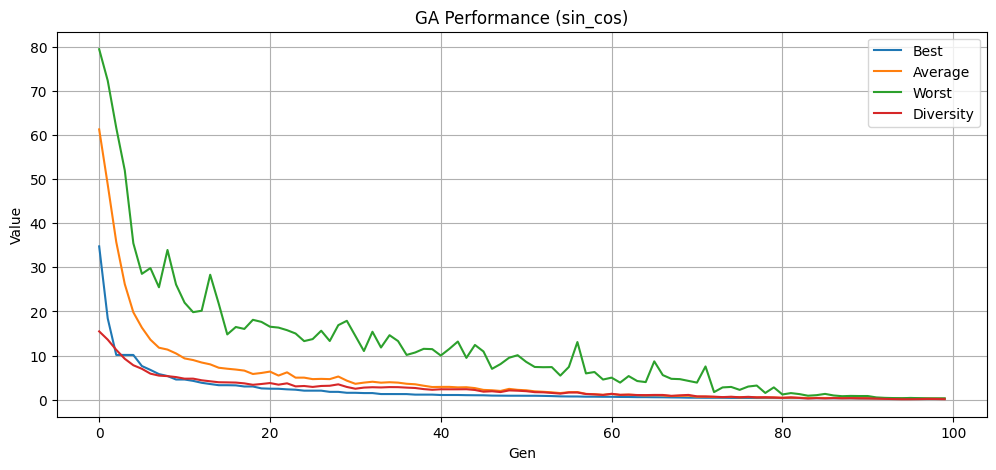


=== Final Metrics for Best Individual ===
RMSE: 0.473838
MAE: 0.383384
MSE: 0.224522
Max Error: 1.059960
R²: 0.633539
MAPE (%): 89.097877
Weighted RMSE: 0.482640
Frequency Domain Error: 2.629128
Normalized Cross-Correlation: 0.891760


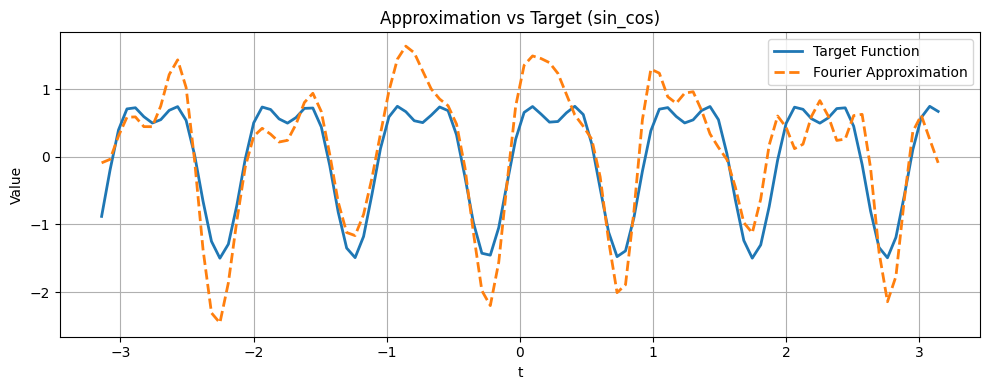

In [188]:
examp_functions = ['sin_cos','linear','quadratic', 'guassian']
results = {}
ga_sin_cos = GeneticAlgorithm(target_function_name="sin_cos",
                      fitness_metric="mse",
                      selection_method="tournament",
                      crossover_method="arithmetic",
                      mutation_strategy="gaussian")


ga_gaussian = GeneticAlgorithm(target_function_name="guassian",
                      fitness_metric="mse",
                      selection_method="tournament",
                      crossover_method="arithmetic",
                      mutation_strategy="gaussian")

ga_sin_cos.evolve()
ga_sin_cos.all_metrics = ga_sin_cos.calculate_all_metrics(ga_sin_cos.best_ind)
ga_sin_cos.plot_results()
ga_sin_cos.plot_approximation_vs_target()

Now we test this algorithm for other functions:

Evolving(linear):   1%|          | 1/100 [00:00<00:37,  2.66it/s]

Generation 0: Best MSE = 42.382461


Evolving(linear):  11%|█         | 11/100 [00:03<00:31,  2.84it/s]

Generation 10: Best MSE = 8.629735


Evolving(linear):  21%|██        | 21/100 [00:07<00:28,  2.75it/s]

Generation 20: Best MSE = 6.168061


Evolving(linear):  31%|███       | 31/100 [00:11<00:25,  2.76it/s]

Generation 30: Best MSE = 4.759922


Evolving(linear):  41%|████      | 41/100 [00:14<00:21,  2.73it/s]

Generation 40: Best MSE = 3.406202


Evolving(linear):  51%|█████     | 51/100 [00:18<00:17,  2.77it/s]

Generation 50: Best MSE = 2.923845


Evolving(linear):  61%|██████    | 61/100 [00:21<00:14,  2.74it/s]

Generation 60: Best MSE = 2.528793


Evolving(linear):  71%|███████   | 71/100 [00:25<00:10,  2.85it/s]

Generation 70: Best MSE = 2.198318


Evolving(linear):  81%|████████  | 81/100 [00:29<00:06,  2.79it/s]

Generation 80: Best MSE = 1.953794


Evolving(linear):  91%|█████████ | 91/100 [00:32<00:03,  2.72it/s]

Generation 90: Best MSE = 1.762903


Evolving(linear): 100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


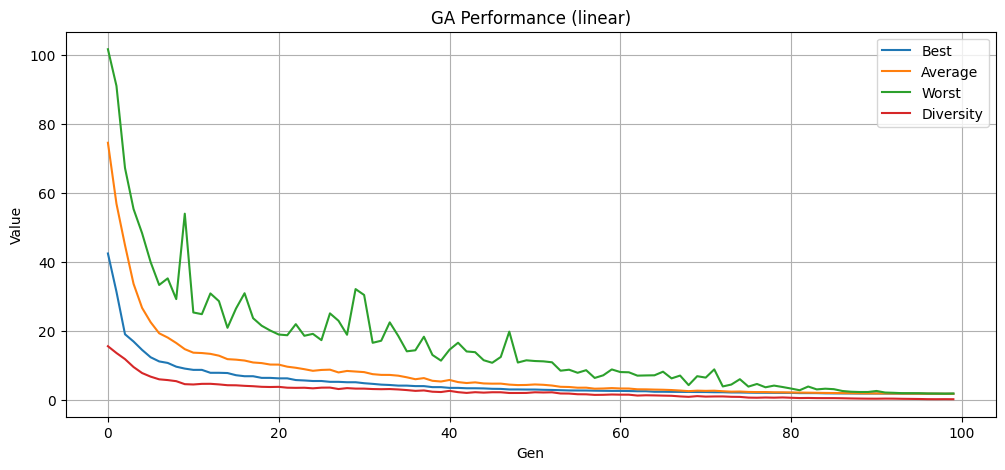


=== Final Metrics for Best Individual ===
RMSE: 1.303068
MAE: 0.906347
MSE: 1.697985
Max Error: 6.463610
R²: 0.873524
MAPE (%): 55.148636
Weighted RMSE: 0.024813
Frequency Domain Error: 6.279919
Normalized Cross-Correlation: 0.947817


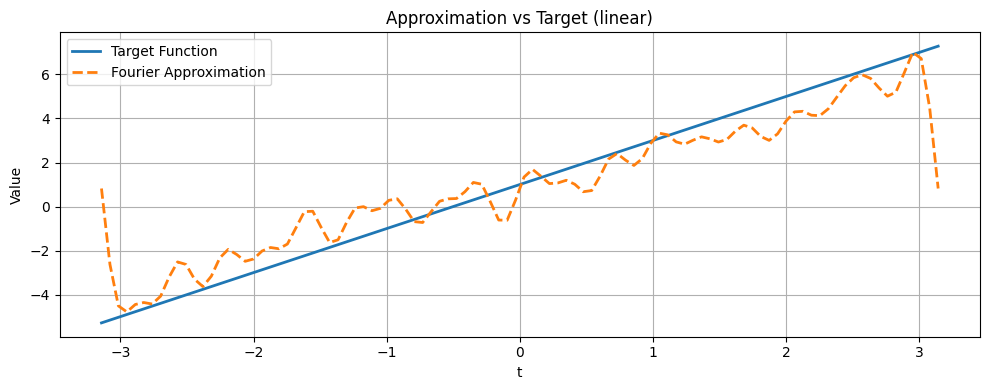

In [189]:
ga_linear = GeneticAlgorithm(target_function_name="linear",
                      fitness_metric="mse",
                      selection_method="tournament",
                      crossover_method="arithmetic",
                      mutation_strategy="gaussian")

ga_linear.evolve()
ga_linear.all_metrics = ga_linear.calculate_all_metrics(ga_linear.best_ind)
ga_linear.plot_results()
ga_linear.plot_approximation_vs_target()

Evolving(linear):   1%|          | 1/100 [00:00<00:35,  2.78it/s]

Generation 0: Best NORMALIZED_CROSS_CORRELATION = 0.374732


Evolving(linear):  11%|█         | 11/100 [00:04<00:34,  2.55it/s]

Generation 10: Best NORMALIZED_CROSS_CORRELATION = 0.609061


Evolving(linear):  21%|██        | 21/100 [00:08<00:30,  2.57it/s]

Generation 20: Best NORMALIZED_CROSS_CORRELATION = 0.715373


Evolving(linear):  31%|███       | 31/100 [00:12<00:31,  2.18it/s]

Generation 30: Best NORMALIZED_CROSS_CORRELATION = 0.796078


Evolving(linear):  41%|████      | 41/100 [00:17<00:33,  1.74it/s]

Generation 40: Best NORMALIZED_CROSS_CORRELATION = 0.858756


Evolving(linear):  51%|█████     | 51/100 [00:22<00:21,  2.23it/s]

Generation 50: Best NORMALIZED_CROSS_CORRELATION = 0.889733


Evolving(linear):  61%|██████    | 61/100 [00:26<00:17,  2.26it/s]

Generation 60: Best NORMALIZED_CROSS_CORRELATION = 0.925439


Evolving(linear):  71%|███████   | 71/100 [00:31<00:13,  2.21it/s]

Generation 70: Best NORMALIZED_CROSS_CORRELATION = 0.943116


Evolving(linear):  81%|████████  | 81/100 [00:35<00:07,  2.70it/s]

Generation 80: Best NORMALIZED_CROSS_CORRELATION = 0.952584


Evolving(linear):  91%|█████████ | 91/100 [00:38<00:03,  2.68it/s]

Generation 90: Best NORMALIZED_CROSS_CORRELATION = 0.957554


Evolving(linear): 100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


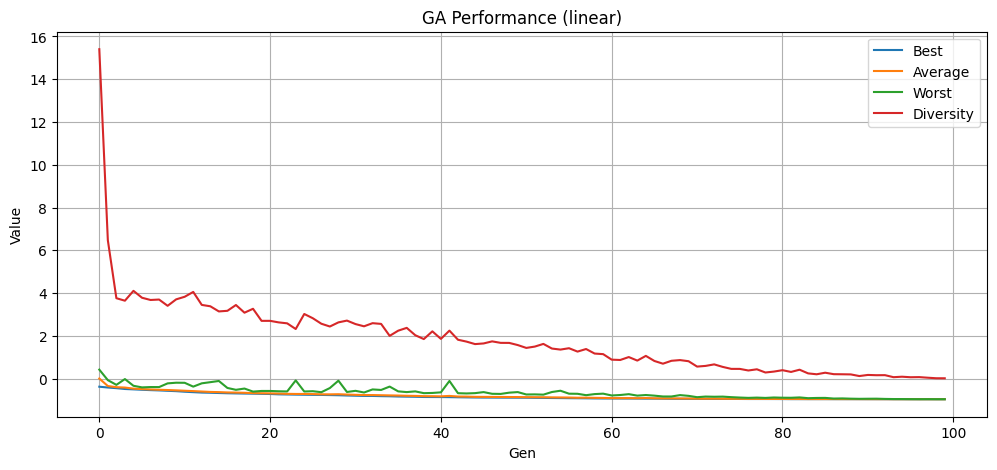


=== Final Metrics for Best Individual ===
RMSE: 2.812521
MAE: 2.576553
MSE: 7.910275
Max Error: 8.694270
R²: 0.410794
MAPE (%): 206.719317
Weighted RMSE: 0.077071
Frequency Domain Error: 6.773394
Normalized Cross-Correlation: 0.959727


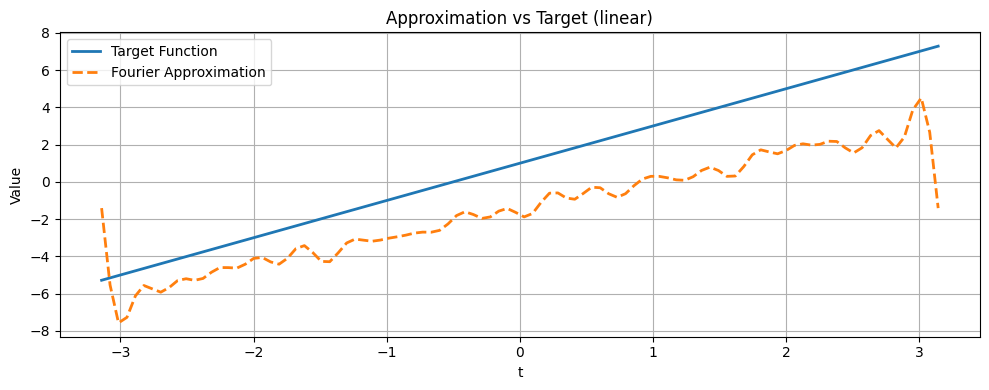

In [190]:
ga_linear = GeneticAlgorithm(target_function_name="linear",
                      fitness_metric="normalized_cross_correlation",
                      selection_method="roulette",
                      crossover_method="arithmetic",
                      mutation_strategy="gaussian")

ga_linear.evolve()
ga_linear.all_metrics = ga_linear.calculate_all_metrics(ga_linear.best_ind)
ga_linear.plot_results()
ga_linear.plot_approximation_vs_target()

### After implementing smoothing methods (on report), I reached a new class for genetic algorithm:

In [184]:
NUM_COEFFS = 41  # a0 + 20 a_n + 20 b_n
MUTATION_RATE = 0.05
ELITISM_COUNT = 14

In [185]:
class GeneticFourier:
    def __init__(self, target_fn, population_size=100, generations=200, adaptive=True, mutation_strategy="gaussian", selection_method="tournament"):
        self.target_fn = target_fn
        self.pop_size = population_size
        self.gens = generations
        self.adaptive = adaptive
        self.mutation_strategy = mutation_strategy
        self.selection_method = selection_method

        self.t_vals = np.linspace(0, 2 * np.pi, 500)
        self.target_vals = target_fn(self.t_vals)

        self._prepare_basis()
        self.population = self._init_population()
        self.best_ind = None
        self.history = []

    def _prepare_basis(self):
        self.cos_basis = np.array([np.cos(n * self.t_vals) for n in range(1, 21)])
        self.sin_basis = np.array([np.sin(n * self.t_vals) for n in range(1, 21)])

    def _init_population(self):
        return [np.random.uniform(-1, 1, NUM_COEFFS) for _ in range(self.pop_size)]

    def _fourier(self, coeffs):
        a0 = coeffs[0] / 2
        a = coeffs[1:21]
        b = coeffs[21:]
        return a0 + np.dot(a, self.cos_basis) + np.dot(b, self.sin_basis)

    def _eval(self, coeffs):
        approx_vals = self._fourier(coeffs)
        return np.mean((approx_vals - self.target_vals) ** 2)

    def _select(self):
        if self.selection_method == "tournament":
            return self._tournament_selection()
        else:
            return self._rank_selection()

    def _tournament_selection(self, k=3):
        selected = []
        for _ in range(self.pop_size):
            competitors = random.sample(self.population, k)
            selected.append(min(competitors, key=self._eval))
        return selected

    def _rank_selection(self):
        ranked = sorted(self.population, key=self._eval)
        weights = np.arange(len(ranked), 0, -1)
        probs = weights / np.sum(weights)
        selected = random.choices(ranked, weights=probs, k=self.pop_size)
        return selected

    def _crossover(self, parent1, parent2):
        alpha = np.random.rand()
        return alpha * parent1 + (1 - alpha) * parent2

    def _mutate(self, coeffs):
        new = coeffs.copy()
        for i in range(len(new)):
            if np.random.rand() < self.mut_rate:
                if self.mutation_strategy == "gaussian":
                    new[i] += np.random.normal(0, 0.05)
                elif self.mutation_strategy == "uniform":
                    new[i] = np.random.uniform(-1, 1)
        return new

    def _adjust_parameters(self, gen):
        if self.adaptive:
            self.mut_rate = MUTATION_RATE * (1 - gen / self.gens)
        else:
            self.mut_rate = MUTATION_RATE

    def evolve(self):
        for gen in range(self.gens):
            self._adjust_parameters(gen)
            selected = self._select()
            next_gen = []

            # Elitism
            elites = sorted(self.population, key=self._eval)[:ELITISM_COUNT]
            next_gen.extend(elites)

            while len(next_gen) < self.pop_size:
                p1, p2 = random.sample(selected, 2)
                child = self._crossover(p1, p2)
                child = self._mutate(child)
                next_gen.append(child)

            self.population = next_gen
            best = min(self.population, key=self._eval)
            self.history.append(self._eval(best))
            if self.best_ind is None or self._eval(best) < self._eval(self.best_ind):
                self.best_ind = best

            if gen % 20 == 0 or gen == self.gens - 1:
                print(f"Generation {gen:03}: Best MSE = {self._eval(self.best_ind):.6f}")

    def plot_results(self):
        plt.figure(figsize=(10, 4))
        plt.plot(self.history, label='MSE over generations', color='teal')
        plt.xlabel("Generation")
        plt.ylabel("MSE")
        plt.title("Fitness Evolution")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_approximation_vs_target(self):
        approx_vals = self._fourier(self.best_ind)
        plt.figure(figsize=(10, 4))
        plt.plot(self.t_vals, self.target_vals, label="Target Function", lw=2)
        plt.plot(self.t_vals, approx_vals, label="GA Approximation", lw=2, linestyle='--')
        plt.title("Target vs Approximation")
        plt.xlabel("t")
        plt.ylabel("f(t)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def save_best(self, filename="best_coeffs.npy"):
        np.save(filename, self.best_ind)

    def load_best(self, filename="best_coeffs.npy"):
        self.best_ind = np.load(filename)

An example for the enhanced class:

Generation 000: Best MSE = 2.005715
Generation 020: Best MSE = 0.256222
Generation 040: Best MSE = 0.127467
Generation 060: Best MSE = 0.046517
Generation 080: Best MSE = 0.016260
Generation 100: Best MSE = 0.004800
Generation 120: Best MSE = 0.002028
Generation 140: Best MSE = 0.000990
Generation 160: Best MSE = 0.000635
Generation 180: Best MSE = 0.000442
Generation 200: Best MSE = 0.000347
Generation 220: Best MSE = 0.000299
Generation 240: Best MSE = 0.000257
Generation 249: Best MSE = 0.000255


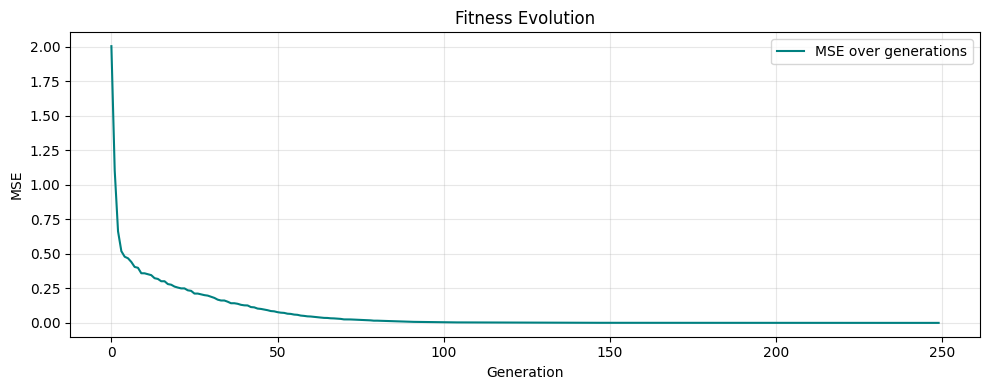

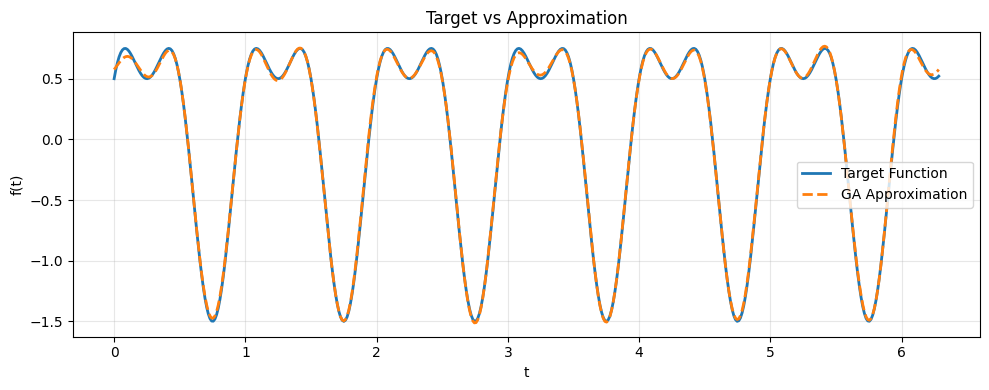

Generation 000: Best MSE = 61.264752
Generation 020: Best MSE = 56.062538
Generation 040: Best MSE = 53.099148
Generation 060: Best MSE = 50.638206
Generation 080: Best MSE = 48.667844
Generation 100: Best MSE = 46.341747
Generation 120: Best MSE = 44.845961
Generation 140: Best MSE = 43.046489
Generation 160: Best MSE = 41.474780
Generation 180: Best MSE = 40.349053
Generation 200: Best MSE = 39.315396
Generation 220: Best MSE = 38.238686
Generation 240: Best MSE = 37.075291
Generation 249: Best MSE = 36.872294


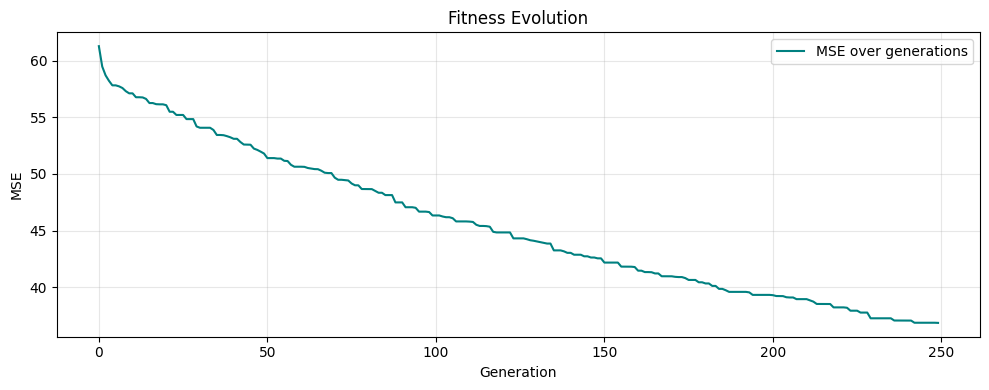

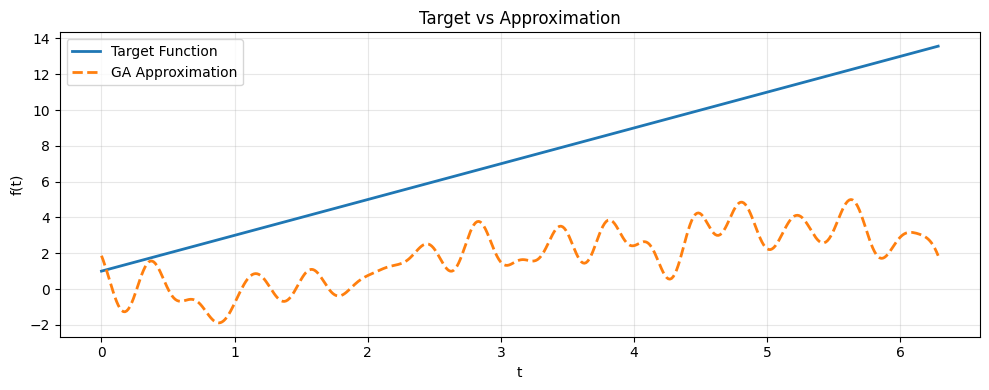

Generation 000: Best MSE = 3284.544609
Generation 020: Best MSE = 3267.699952
Generation 040: Best MSE = 3247.366406
Generation 060: Best MSE = 3228.211882
Generation 080: Best MSE = 3211.998212
Generation 100: Best MSE = 3192.026032
Generation 120: Best MSE = 3176.025407
Generation 140: Best MSE = 3161.719310
Generation 160: Best MSE = 3143.093488
Generation 180: Best MSE = 3128.062844
Generation 200: Best MSE = 3114.915524
Generation 220: Best MSE = 3103.796989
Generation 240: Best MSE = 3096.034877
Generation 249: Best MSE = 3091.800161


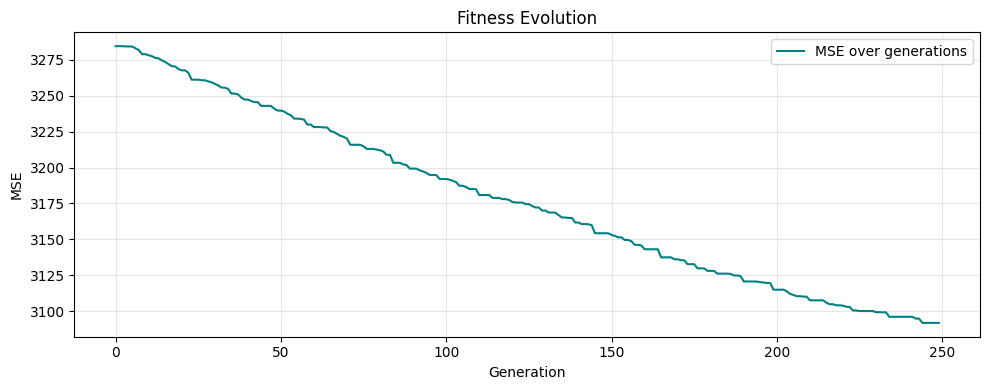

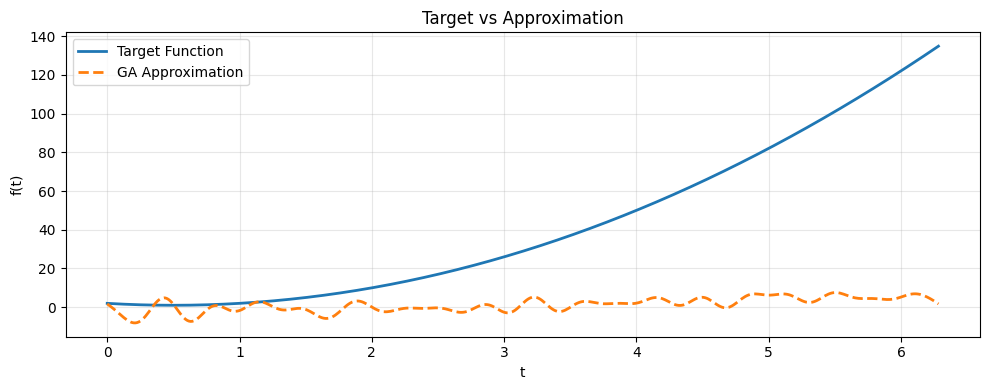

Generation 000: Best MSE = 316223.561134
Generation 020: Best MSE = 316059.332567
Generation 040: Best MSE = 315844.722278
Generation 060: Best MSE = 315655.314061
Generation 080: Best MSE = 315474.776474
Generation 100: Best MSE = 315326.464583
Generation 120: Best MSE = 315143.689452
Generation 140: Best MSE = 314971.754936
Generation 160: Best MSE = 314846.402589
Generation 180: Best MSE = 314721.433778
Generation 200: Best MSE = 314586.723595
Generation 220: Best MSE = 314475.485665
Generation 240: Best MSE = 314408.893580
Generation 249: Best MSE = 314392.398164


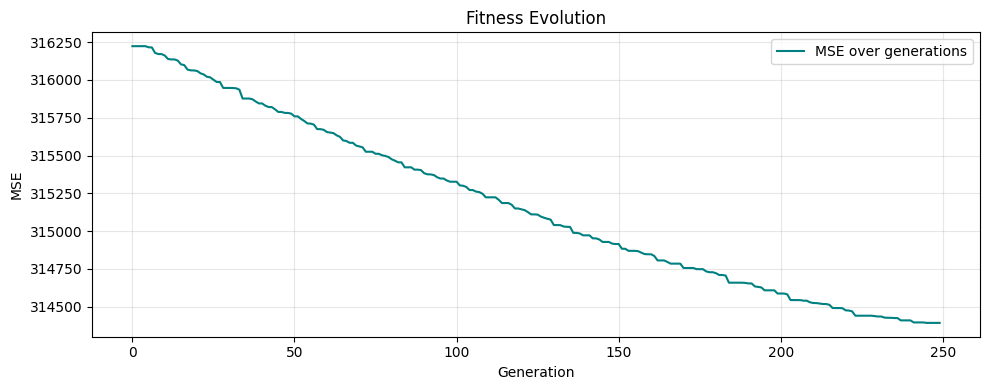

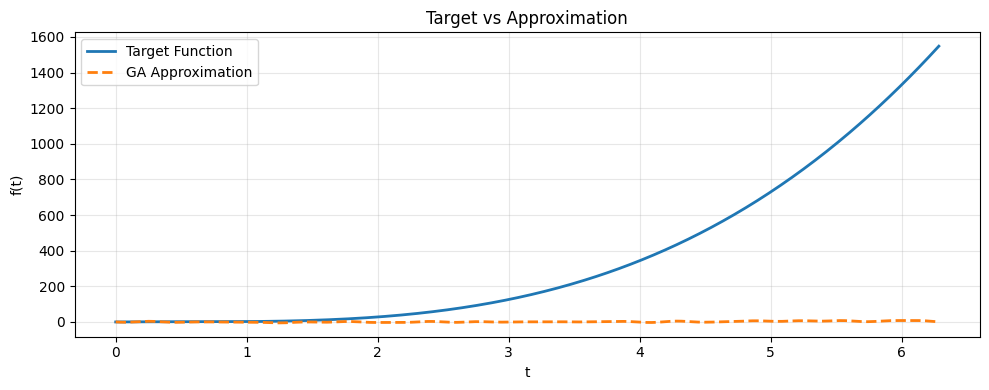

Generation 000: Best MSE = 2.266265
Generation 020: Best MSE = 0.071927
Generation 040: Best MSE = 0.022364
Generation 060: Best MSE = 0.004952
Generation 080: Best MSE = 0.001756
Generation 100: Best MSE = 0.000955
Generation 120: Best MSE = 0.000605
Generation 140: Best MSE = 0.000401
Generation 160: Best MSE = 0.000281
Generation 180: Best MSE = 0.000222
Generation 200: Best MSE = 0.000192
Generation 220: Best MSE = 0.000176
Generation 240: Best MSE = 0.000162
Generation 249: Best MSE = 0.000162


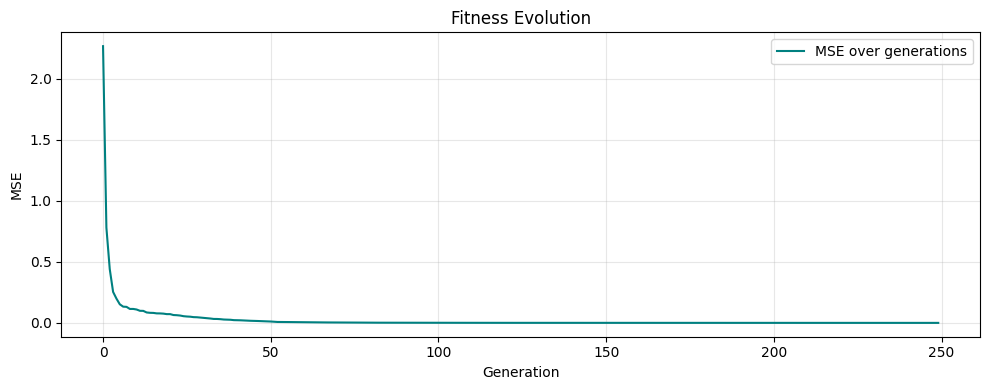

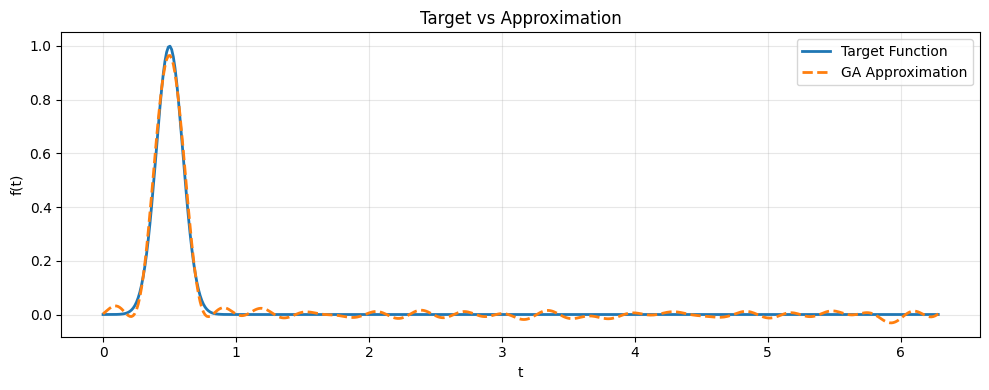

Generation 000: Best MSE = 2.558540
Generation 020: Best MSE = 0.324093
Generation 040: Best MSE = 0.201908
Generation 060: Best MSE = 0.111391
Generation 080: Best MSE = 0.057708
Generation 100: Best MSE = 0.033763
Generation 120: Best MSE = 0.027563
Generation 140: Best MSE = 0.025652
Generation 160: Best MSE = 0.024788
Generation 180: Best MSE = 0.024501
Generation 200: Best MSE = 0.024352
Generation 220: Best MSE = 0.024236
Generation 240: Best MSE = 0.024193
Generation 249: Best MSE = 0.024186


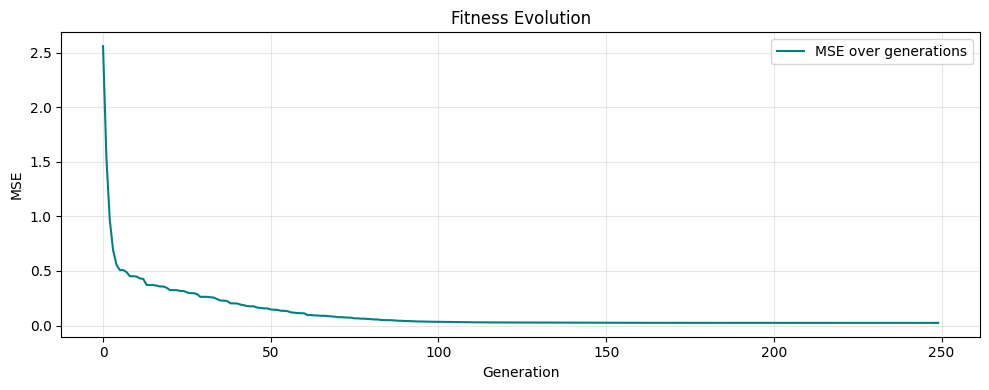

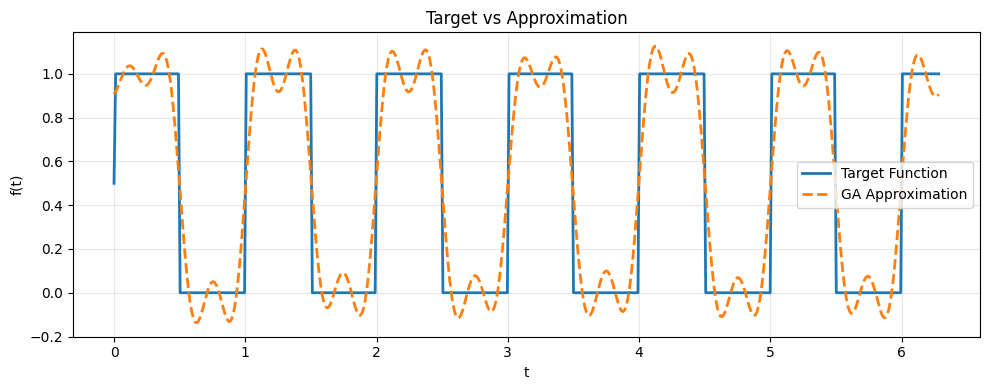

Generation 000: Best MSE = 2.293478
Generation 020: Best MSE = 0.348579
Generation 040: Best MSE = 0.215680
Generation 060: Best MSE = 0.138628
Generation 080: Best MSE = 0.100293
Generation 100: Best MSE = 0.088114
Generation 120: Best MSE = 0.084610
Generation 140: Best MSE = 0.083291
Generation 160: Best MSE = 0.082867
Generation 180: Best MSE = 0.082642
Generation 200: Best MSE = 0.082588
Generation 220: Best MSE = 0.082544
Generation 240: Best MSE = 0.082527
Generation 249: Best MSE = 0.082522


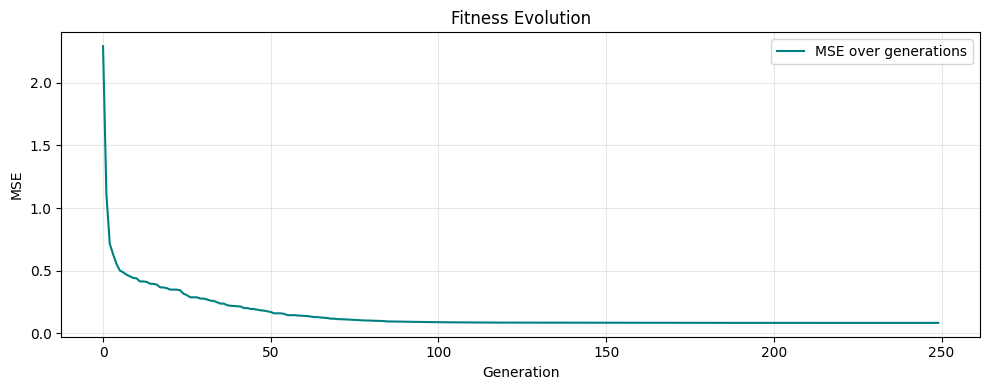

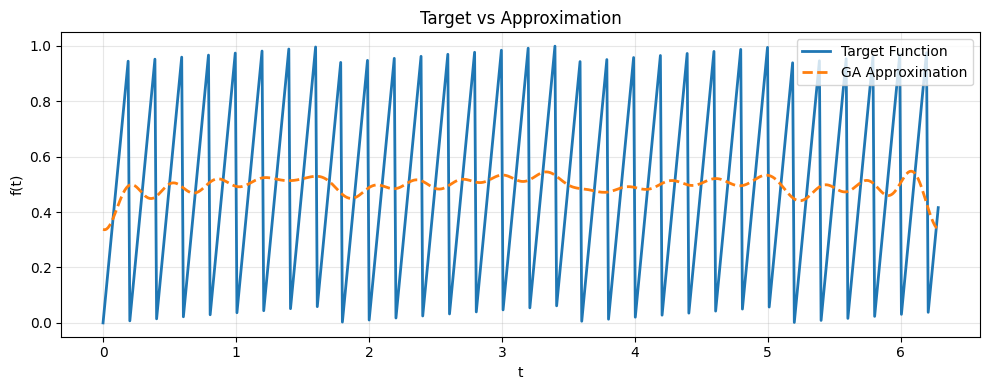

Generation 000: Best MSE = 2.210128
Generation 020: Best MSE = 0.345472
Generation 040: Best MSE = 0.181485
Generation 060: Best MSE = 0.084894
Generation 080: Best MSE = 0.031309
Generation 100: Best MSE = 0.014560
Generation 120: Best MSE = 0.008869
Generation 140: Best MSE = 0.006846
Generation 160: Best MSE = 0.005779
Generation 180: Best MSE = 0.005377
Generation 200: Best MSE = 0.005236
Generation 220: Best MSE = 0.005095
Generation 240: Best MSE = 0.005059
Generation 249: Best MSE = 0.005050


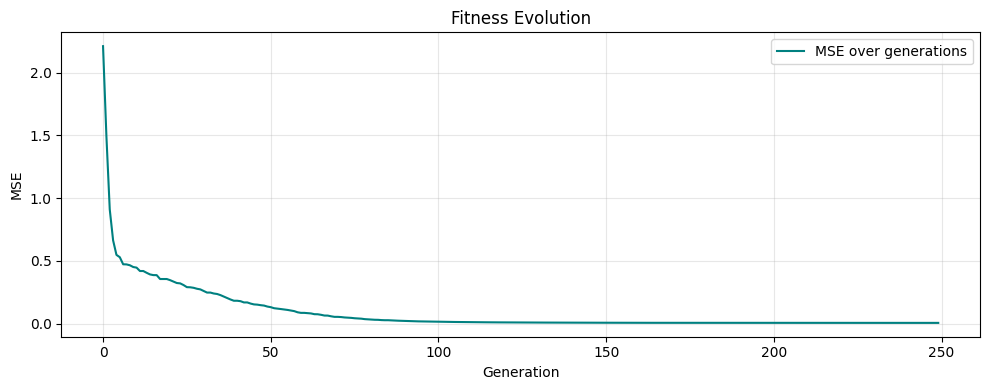

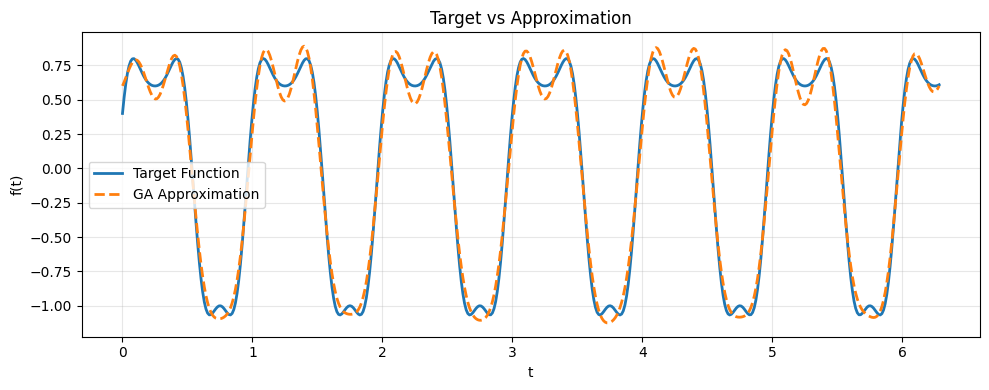

Generation 000: Best MSE = 424766381.256547
Generation 020: Best MSE = 424760131.231889
Generation 040: Best MSE = 424753540.783443
Generation 060: Best MSE = 424745814.794170
Generation 080: Best MSE = 424738583.476371
Generation 100: Best MSE = 424731370.003114
Generation 120: Best MSE = 424725106.604162
Generation 140: Best MSE = 424719319.588673
Generation 160: Best MSE = 424713441.292929
Generation 180: Best MSE = 424709248.063632
Generation 200: Best MSE = 424704143.107114
Generation 220: Best MSE = 424701185.366451
Generation 240: Best MSE = 424697028.849458
Generation 249: Best MSE = 424696999.520321


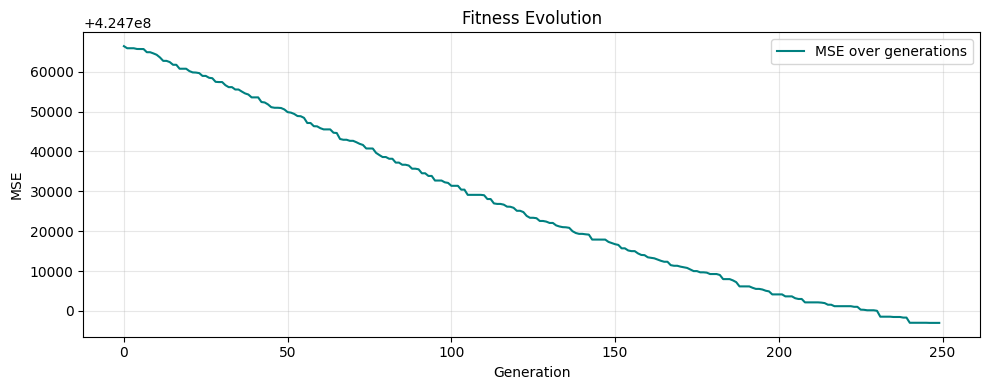

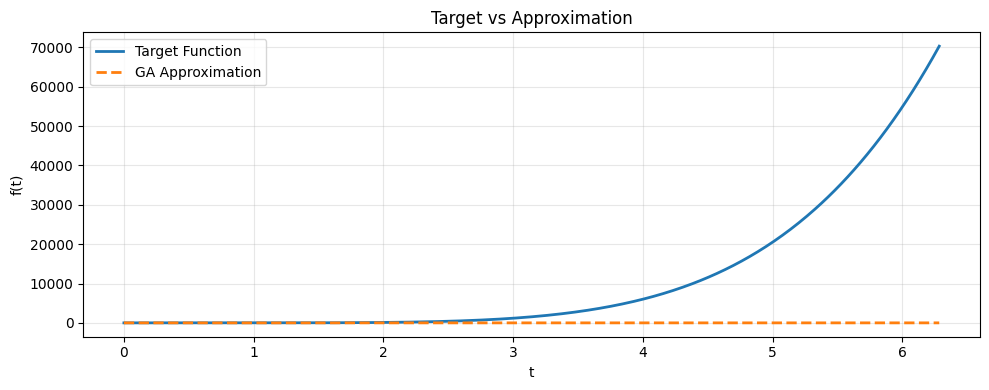

In [186]:
target_functions = [
    "sin_cos",
    "linear",
    "quadratic",
    "cubic",
    "gaussian",
    "square_wave",
    "sawtooth",
    "complex_fourier",
    "polynomial",
]

ga_results = []

for f_name in target_functions:       
    target_fn = get_target_function(f_name)
    ga = GeneticFourier (
        target_fn,
        population_size=120,
        generations=250,
        adaptive=True,
        mutation_strategy="gaussian",
        selection_method="tournament"
    )

    ga.evolve()
    ga.plot_results()
    ga.plot_approximation_vs_target()
    ga.save_best()
    ga_results.append(ga)



There is a trade-off with the observations. If we want to achieve a relatively good result for most functions, we use the first model. If we want to achieve an excellent result for intermittent functions but for other functions the result is negligible, the second model is a unique choice.